In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [8]:
#CARREGAR OS DADOS X
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)

# Selecionar os índices com base nos critérios fornecidos
ecg_normal_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_AF_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == True)  ]
ecg_ST_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == True) & (dados.iloc[:, 9] == False)  ]
ecg_1dAVb_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == True) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)  ]
ecg_SB_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == True) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)  ]
ecg_todos_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) ]

ecg_normal_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_ST_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == True) & (dados.iloc[:, 9] == False)  ]


ecg_ST_id = dados.iloc[ecg_ST_linhas, 0].tolist()
ecg_1dAVb_id = dados.iloc[ecg_1dAVb_linhas, 0].tolist()

ecg_AF_id = dados.iloc[ecg_AF_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
ecg_SB_id = dados.iloc[ecg_SB_linhas, 0].tolist()
ecg_todos_id = dados.iloc[ecg_todos_linhas, 0].tolist()




ecg_ST = ecg_ST_id[:500]
ecg_normal = ecg_normal_id[:10000]
ecg_SB = ecg_SB_id[:300]


ids_ecgs= ecg_ST +ecg_normal



In [3]:
#CARREGAR OS DADOS X_TREINO
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)

# Selecionar os índices com base nos critérios fornecidos
ecg_normal_linhas = dados.index[((dados.iloc[:, 14] == "exams_part15.hdf5") | (dados.iloc[:, 14] == "exams_part14.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_ST_linhas = dados.index[((dados.iloc[:, 14] == "exams_part15.hdf5") | (dados.iloc[:, 14] == "exams_part14.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == True) & (dados.iloc[:, 9] == False)  ]
ecg_SB_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == True) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)  ]


ecg_ST_id = dados.iloc[ecg_ST_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
ecg_SB_id = dados.iloc[ecg_SB_linhas, 0].tolist()




ecg_ST = ecg_ST_id[:500]
ecg_normal = ecg_normal_id[:10000]
ecg_SB = ecg_SB_id[:300]



ids_ecgs_treino = ecg_ST 

In [9]:
#X

import h5py
import numpy as np

# Função para obter dados de ECG a partir do arquivo HDF5
def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

# Caminho para o arquivo HDF5
path_to_file = '../Database/filtered_exams_16_17.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs # Substitua pelos IDs reais dos exames

# Define o tamanho do memmap baseado no número de exames
num_exams = len(exam_ids_to_cluster)
shape = (num_exams, 12, 4096)  # Atualize a shape conforme necessário

# Cria um arquivo memmap para armazenar os dados
X = np.memmap('data.dat', dtype='float32', mode='w+', shape=shape)

# Obter os tracings de ECG para cada exam_id e armazenar no memmap
for i, exam_id in enumerate(exam_ids_to_cluster):
    tracings = get_ecg_data(path_to_file, exam_id)
    X[i] = tracings.T

# Usando squeeze
X = np.squeeze(X[:, 1, :])

# Agora você pode usar X_squeezed para os próximos passos de processamento


OSError: [Errno 22] Invalid argument: 'abc.dat'

In [30]:
#X_TREINO
path_to_file = '../Database/filtered_exams_14_15.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster_treino = ids_ecgs_treino  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster_treino:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X_TREINO = np.array(all_tracings)
 
# Usando squeeze
X_TREINO = np.squeeze(X_TREINO[:, 1, :])

In [6]:
#CARREGAR MODELO

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

# Define the encoder
def encoder_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    encoded = Conv1D(filters=1, kernel_size=16, strides=1, padding='same')(x)

    return Model(inputs, encoded, name="encoder")

# Define the decoder
def decoder_model(encoded_shape):
    inputs = Input(shape=encoded_shape)
    x = Conv1DTranspose(filters=40, kernel_size=16, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    decoded = Conv1DTranspose(filters=1, kernel_size=16, strides=2, padding='same')(x)

    return Model(inputs, decoded, name="decoder")

# Define the full autoencoder
def autoencoder_model(input_shape):
    encoder = encoder_model(input_shape)
    decoder = decoder_model(encoder.output_shape[1:])
    
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = Model(inputs, decoded, name="autoencoder")
    
    return autoencoder




Epoch 1/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 122s 180ms/step - loss: 0.0310 - val_loss: 0.0040
Epoch 2/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 115s 178ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 113s 176ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 4/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 116s 180ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 126s 195ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 6/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 117s 181ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 115s 178ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 112s 174ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 114s 177ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 114s 176ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 112s 174ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12

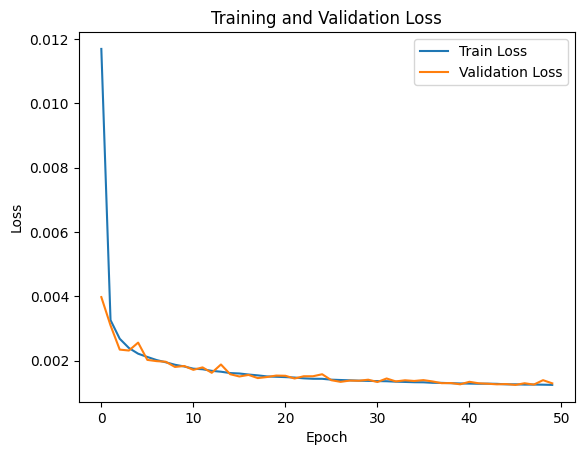

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


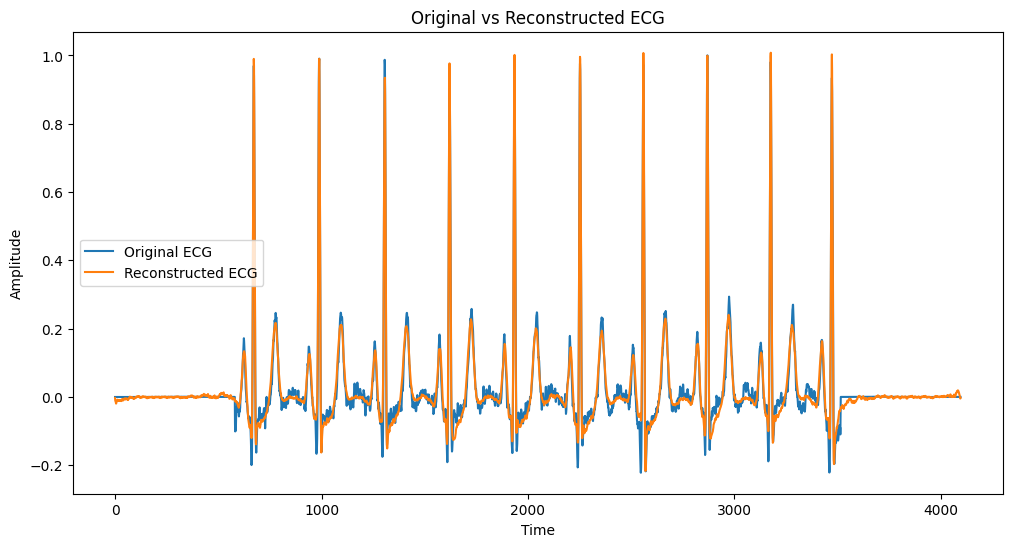

In [8]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

path_to_file = '../Database/filtered_exams_16_17.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Define o tamanho do memmap baseado no número de exames
num_exams = len(exam_ids_to_cluster)
shape = (num_exams, 12, 4096)  # Atualize a shape conforme necessário

# Cria um arquivo memmap para armazenar os dados
X = np.memmap('teste.dat', dtype='float32', mode='w+', shape=shape)

# Obter os tracings de ECG para cada exam_id e armazenar no memmap
for i, exam_id in enumerate(exam_ids_to_cluster):
    tracings = get_ecg_data(path_to_file, exam_id)
    X[i] = tracings.T

# Usando squeeze
X = np.squeeze(X[:, 1, :])

epsilon = 1e-8  # Pequeno valor para evitar divisão por zero
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Definir o autoencoder
autoencoder = autoencoder_model((4096, 1))
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('autoencoder_model_todos.keras')

# Salvar o modelo treinado
autoencoder.save('autoencoder_model_todos.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


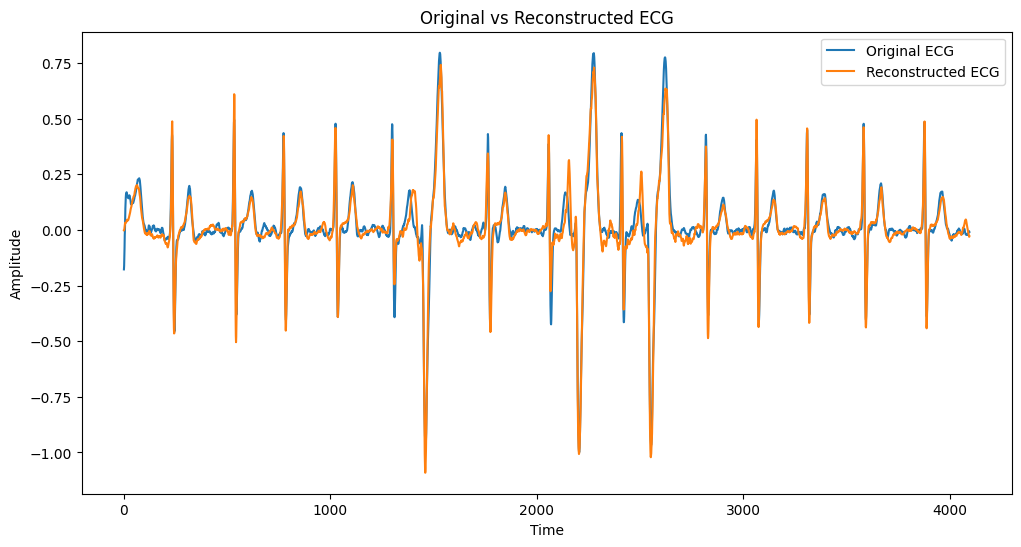

In [33]:
#VER RECONSTRUCAO

# Carregar o modelo salvo no formato Keras
autoencoder = load_model('autoencoder_model_todos.keras')

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Normalizar os dados entre 0 e 1 (caso ainda não esteja feito)
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Selecionar um exemplo de ECG para reconstruir
idx = 10
original_ecg = X[idx]

# Reconstruir o ECG usando o autoencoder carregado
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

In [60]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
epsilon = 1e-8  # Pequeno valor para evitar divisão por zero
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


806/806 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step
(25779, 128, 1)
(25779, 128)


In [6]:
#DIMINUIR DIMENSAO DE X_TREINO PELO AUTOENCODER(128)


# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X_TREINO já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X_TREINO = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X_TREINO = X_TREINO / np.max(np.abs(X_TREINO), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X_TREINO = X_TREINO.reshape((X_TREINO.shape[0], X_TREINO.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X_TREINO
X_TREINO_encoded = encoder.predict(X_TREINO)

# X_encoded agora contém os vetores de 128 números para cada entrada em X_TREINO


# Remover a última dimensão para obter um vetor 2D
X_TREINO_encoded_2d = np.squeeze(X_TREINO_encoded)
print(X_TREINO_encoded_2d.shape)  # Deve ser (10500, 128)



c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'X_TREINO' is not defined

In [61]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
nan_mask = np.isnan(X_encoded_2d)
means = np.nanmean(X_encoded_2d, axis=0)
X_encoded_2d[nan_mask] = np.take(means, np.where(nan_mask)[1])

# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

scaler2 = StandardScaler()
X_reduced_scaled = scaler2.fit_transform(X_reduced)

In [32]:
#DIMINUIR DIMENSAO DE X_TREINO PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
X_TREINO_normalized = scaler.transform(X_TREINO_encoded_2d)
# Aplicação do UMAP

X_TREINO_reduced = umap_reducer.transform(X_TREINO_normalized)

X_TREINO_reduced_scaled = scaler2.transform(X_TREINO_reduced)

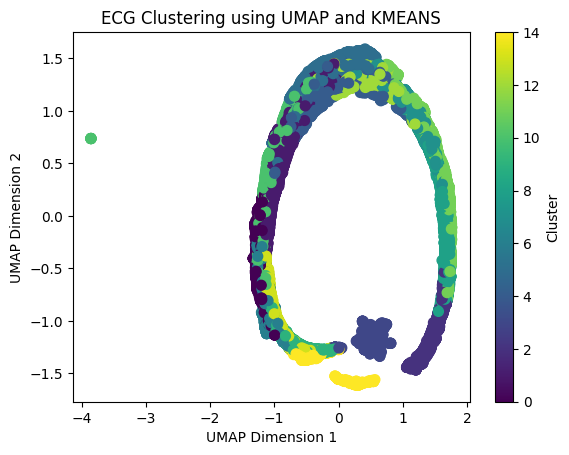

Silhouette Score: 0.36254629492759705
    cluster  1dAVb  RBBB  LBBB   SB   ST   AF  normal_ecg
0         0     34    35    27    1   13   19         851
1         1     45    56    55    1   17   34        1400
2         2     20    23    24    0  151   28         581
3         3     71   119    60  160   55  340         245
4         4     28    46    27    1    7   31        1223
5         5     22    46    24    1    4   21         900
6         6     23    21    19    3   20    9         561
7         7     24    36    23    3    2   13         907
8         8     14    24    25    1    2   21         719
9         9     37    54    20  122   14   18         559
10       10     48    53    33    0    9   15        1012
11       11     19    32    28    4    2   21         876
12       12     18    32    28    1    4   13         818
13       13     44    46    31    6   59   13         828
14       14     31    21    20   55  246    9         306


In [76]:
#CLUSTERIZACAO 

kmeans = KMeans(n_clusters=15,random_state=42)
kmeans.fit(X_reduced_scaled)
labels = kmeans.labels_
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and KMEANS')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

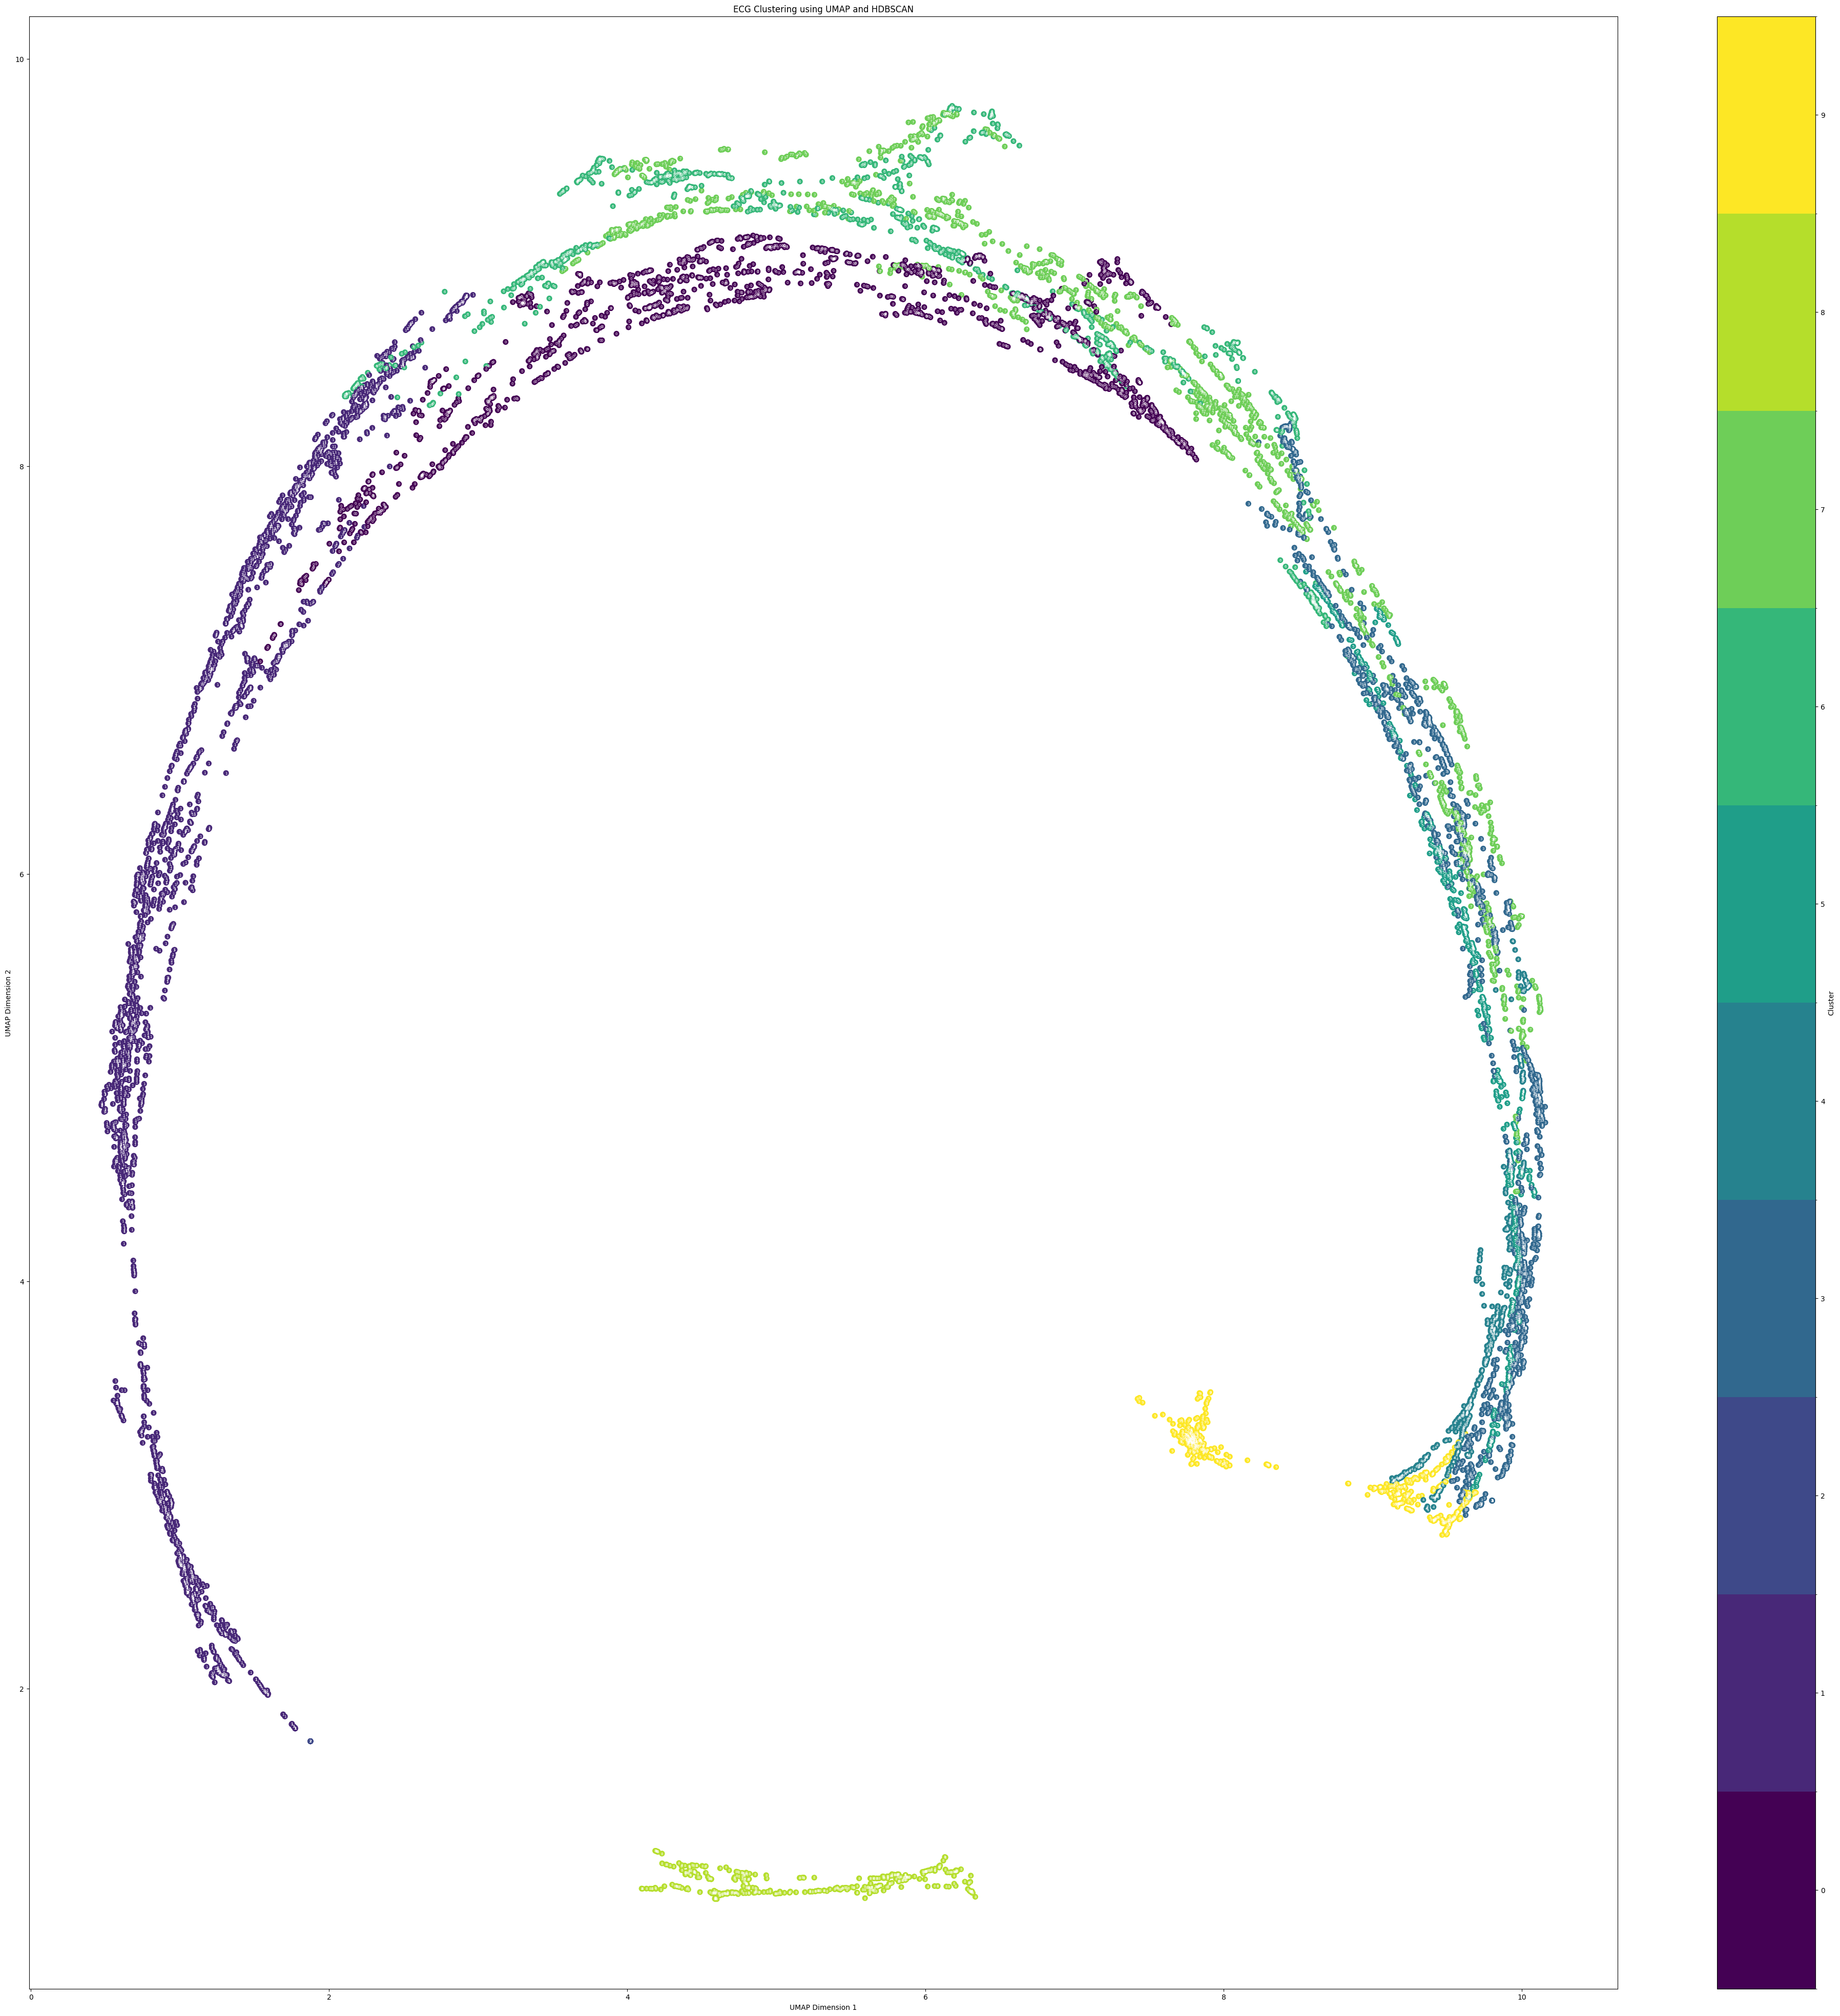

In [36]:
#IMAGEM GRANDE

unique_labels = np.unique(labels)
plt.figure(figsize=(50, 50))

cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))

# Definindo os limites para a color bar
norm = BoundaryNorm(np.arange(len(unique_labels) + 1) - 0.5, len(unique_labels))

# Plotando o gráfico
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap=cmap, norm=norm, s=50)
# Adicionando os números dos clusters
for i in range(X_reduced.shape[0]):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], str(labels[i]), fontsize=5, ha='center', va='center', color='white')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')

# Adicionando a color bar
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)), boundaries=np.arange(len(unique_labels) + 1) - 0.5)
cbar.set_label('Cluster')
plt.savefig(f'cluster.png', dpi=300)  # Nome do arquivo com o ID
plt.show()

In [49]:
#IDS DENTRO DOS CLUSTERS
import pandas as pd
from sklearn.cluster import DBSCAN

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Criar um dicionário para armazenar os IDs por doença/condição em cada cluster
ids_by_condition = {
    '1dAVb': {},
    'RBBB': {},
    'LBBB': {},
    'SB': {},
    'ST': {},
    'AF': {},
    'normal_ecg': {}
}

# Preencher o dicionário com os IDs correspondentes
for cluster in merged_data['cluster'].unique():
    cluster_data = merged_data[merged_data['cluster'] == cluster]
    for condition in ids_by_condition.keys():
        ids_by_condition[condition][cluster] = cluster_data[cluster_data[condition] == 1]['exam_id'].tolist()

# Exibir os IDs por condição em cada cluster
for condition, clusters in ids_by_condition.items():
    print(f"Condição: {condition}")
    for cluster, ids in clusters.items():
        print(f"  Cluster {cluster}: {ids}")


Condição: 1dAVb
  Cluster 5: []
  Cluster 6: []
  Cluster 4: []
  Cluster 3: []
  Cluster 2: []
  Cluster 0: []
  Cluster 1: []
Condição: RBBB
  Cluster 5: []
  Cluster 6: []
  Cluster 4: []
  Cluster 3: []
  Cluster 2: []
  Cluster 0: []
  Cluster 1: []
Condição: LBBB
  Cluster 5: []
  Cluster 6: []
  Cluster 4: []
  Cluster 3: []
  Cluster 2: []
  Cluster 0: []
  Cluster 1: []
Condição: SB
  Cluster 5: []
  Cluster 6: []
  Cluster 4: []
  Cluster 3: []
  Cluster 2: []
  Cluster 0: []
  Cluster 1: []
Condição: ST
  Cluster 5: [1695452, 1826312, 2024209, 1915489, 2000573, 1826471, 1819139, 1863509, 1947220, 1870388, 1856232, 1841554, 1767311, 1712591, 1682754, 1928946, 1759130, 1797905, 1998775, 1688702, 1706766, 2089276, 1820080, 1926336, 1827889, 1771684, 1698147, 1795349, 1762831, 1686154, 1704985, 1724099, 1702987, 1890933, 1850736, 1724881, 1800132, 1804687, 1819260, 1731262, 1745002, 1861215, 1733367, 1739938, 1779962, 1706971, 1723876, 1751960, 1745386, 1746059, 1925259, 1740456

In [33]:
#PREDIZER O CLUSTER 
# Para predizer novos dados

new_data = X_TREINO_reduced_scaled  # Certifique-se de que seus novos dados estão normalizados corretamente

# Usar o método predict para prever os rótulos dos novos dados
new_labels = kmeans.predict(new_data)

# Configurar para mostrar todos os elementos no print
np.set_printoptions(threshold=np.inf)

print("New labels:", new_labels)

count_3 = np.count_nonzero(new_labels == 2)

print(f"O cluster 2 aparece {count_3} vezes na lista.")

New labels: [5 0 0 0 0 0 0 5 0 0 3 5 0 5 0 3 0 0 4 5 5 5 0 3 5 5 0 5 0 0 0 3 5 0 0 0 0
 0 5 5 0 5 3 5 5 0 5 0 0 3 0 0 0 5 0 0 0 2 0 0 0 5 0 3 3 3 5 0 3 0 0 5 0 0
 0 3 0 0 0 5 0 0 5 0 0 5 0 0 0 0 0 4 0 3 4 0 3 5 0 5 0 0 0 0 5 0 0 0 0 0 0
 4 3 5 0 0 3 0 3 5 0 5 0 0 0 0 4 4 3 0 0 5 5 0 3 5 0 0 0 5 0 0 3 0 0 3 0 4
 0 0 5 0 0 3 0 0 3 3 0 0 0 4 5 4 3 0 0 5 0 4 4 0 0 0 0 0 0 4 0 5 0 5 5 0 3
 0 2 0 3 4 0 0 5 5 0 5 5 0 3 5 0 5 3 0 0 5 3 0 0 0 0 4 0 0 0 0 0 5 0 0 3 0
 5 0 3 0 5 3 3 0 3 3 5 0 0 0 0 0 0 5 3 0 5 5 0 0 0 0 5 0 3 0 3 3 4 3 4 3 3
 0 3 0 0 0 4 3 0 3 0 0 5 0 0 5 3 0 5 5 0 0 5 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0
 0 0 5 0 5 0 0 0 0 5 0 0 0 5 0 0 0 5 5 0 0 5 3 0 0 0 5 5 4 0 3 5 0 5 0 5 0
 0 0 0 0 3 5 5 0 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 5 0 0 5 0 3 3 0 0 3 0 0 0 5
 0 5 0 0 0 3 0 0 0 0 3 5 5 0 0 5 0 0 5 0 0 0 3 5 0 0 3 5 3 0 0 0 3 3 0 4 0
 0 0 3 5 0 3 0 0 0 0 0 5 3 0 0 5 0 5 0 0 0 0 0 3 0 5 5 0 5 5 0 0 4 3 0 0 0
 0 3 5 0 0 5 5 5 0 0 5 0 0 5 0 5 0 4 0 5 0 3 0 0 0 3 0 5 0 0 0 5 5 0 0 0 0
 3 0 0 0 5 0 